# Setup

## Load Dataset

In [1]:
datasets_root = 'datasets'
dataset_id = 'FUNSD_polygon_augmented'

In [2]:
from datasets import Dataset
from pathlib import Path
import json
from datasets import Features, Sequence, ClassLabel, Value, Array2D
from functools import partial
from src.model.processor import Processor
from datasets import DatasetDict
from src.model.lilt import  LiltForTokenClassification
from transformers import AutoConfig
import evaluate
import numpy as np
from transformers import Trainer, TrainingArguments
from PIL import Image, ImageDraw, ImageFont
from src.model.tokenizer import Tokenizer
from src.model.image_processor import ImageProcessor
from src.model.tokenizer import PRETRAINED_VOCAB_FILES_MAP
import torch

### Load dataset
Generate a Dataset object from a generator function that contains the paths of the images and annotations.

In [3]:
def generate_samples(folder):
    images_path = Path(folder) / 'images'
    annotations_path = Path(folder) / 'annotations'
    
    images = list(images_path.glob('*.png'))
    
    for image_path in images:
        image_id = image_path.stem
        annotation_path = annotations_path / f'{image_id}.json'
        yield {
            'image_path': str(image_path),
            'annotation_path': str(annotation_path)
        }

def get_features_type():
    return Features({
        "image_path": Value("string"),
        "annotation_path": Value("string")
    })

def get_dataset_folder(split='train'):
    if split == 'train':
        path = Path(datasets_root) / dataset_id / 'dataset' / 'training_data'
    elif split == 'test':
        path = Path(datasets_root) / dataset_id / 'dataset' / 'testing_data'
    else:
        raise ValueError('split must be either "train" or "test"')
    
    return path



train_folder = get_dataset_folder()
train_dataset = Dataset.from_generator(partial(generate_samples, train_folder), features=get_features_type())
test_folder = get_dataset_folder('test')
test_dataset = Dataset.from_generator(partial(generate_samples, test_folder), features=get_features_type())

# Reduce dataset size
train_dataset = train_dataset.select(range(0, 1000))
test_dataset = test_dataset.select(range(0, 500))

In [4]:
def get_unique_labels(folder):
    annotations_path = Path(folder) / 'annotations'
    unique_labels = set()

    for annotation_file in annotations_path.glob('*.json'):
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)['form']
            for annotation in annotations:
                unique_labels.add(annotation['label'])

    return sorted(list(unique_labels))

labels = get_unique_labels(train_folder)
num_labels = len(labels)
label_to_id = {label: idx for idx, label in enumerate(labels)}
id_to_label = {idx: label for idx, label in enumerate(labels)}

### Preprocess dataset
Load the images and annotations, and encode them using the LayoutLMv3 processor.

In [19]:
# Download vocab and merges files
import requests

files = {
    "vocab_file":PRETRAINED_VOCAB_FILES_MAP['vocab_file']['microsoft/layoutlmv3-base'],
    "merges_file":PRETRAINED_VOCAB_FILES_MAP['merges_file']['microsoft/layoutlmv3-base']
}
saved_paths = {}

for file_name, url in files.items():
    r = requests.get(url, allow_redirects=True)
    saved_path = Path(datasets_root) / 'vocabs' / file_name
    saved_path.parent.mkdir(parents=True, exist_ok=True)
    
    with open(saved_path, 'wb') as f:
        f.write(r.content)
        
    saved_paths[file_name] = str(saved_path)
    
saved_paths

{'vocab_file': 'datasets\\vocabs\\vocab_file',
 'merges_file': 'datasets\\vocabs\\merges_file'}

In [20]:
# Initialize processor
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"
image_processor = ImageProcessor(apply_ocr=False)
tokenizer = Tokenizer(
    vocab_file=saved_paths['vocab_file'],
    merges_file=saved_paths['merges_file'],
    model_max_length=512,
)
processor = Processor(image_processor, tokenizer)
processor.feature_extractor.apply_ocr = False

# Custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(feature=Value(dtype="int64")),
        "polygon": Array2D(dtype="int64", shape=(512, 8)),
        "labels": Sequence(feature=ClassLabel(names=labels)),
    }
)

# Preprocess function
def process(sample):
    # Assume sample["annotation_path"] is the path to the JSON file containing your annotations
    with open(sample["annotation_path"], "r") as f:
        annotations = json.load(f)['form']

    # Extract sequence and bounding polygons from annotations
    tokens = [ann["text"] for ann in annotations]
    polygons = [ann["polygon"] for ann in annotations]  # Modify this if your "polygon" is not actually a bbox
    
    max_length = 512
    padding_length = max_length - len(tokens)

    # Custom Padding for polygons
    # polygons = polygons + [[0, 0, 0, 0, 0, 0, 0, 0] for _ in range(padding_length)]
    
    # Custom Padding for sequence
    # tokens = tokens + ["[PAD]" for _ in range(padding_length)]
    
    # Load image
    image = Image.open(sample["image_path"]).convert("RGB")
    
    # Extract labels for each sequence from annotations
    token_labels = [label_to_id[ann['label']] for ann in annotations]    
    # token_labels = token_labels + [-100 for _ in range(padding_length)]

    # Encoding without 
    encoding = processor(
        image,
        tokens,
        word_labels=token_labels,
        polygons=polygons,
        padding="max_length",
        truncation=True,
    )
    del encoding["pixel_values"]

    return encoding

S:\Projects\polygon-document-comprehension\src\model\processor.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [7]:
# Process your dataset (replace `dataset` with the actual dataset object)
train_dataset = train_dataset.map(
    partial(process),
    remove_columns=["image_path", "annotation_path"],
    features=features,
    load_from_cache_file=False
).with_format("torch")
test_dataset = test_dataset.map(
    partial(process),
    remove_columns=["image_path", "annotation_path"],
    features=features,
    load_from_cache_file=False
).with_format("torch")

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [9]:
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})   
dataset.save_to_disk(Path(datasets_root) / dataset_id / 'huggingface_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

In [10]:
dataset['train']['polygon'][0].shape

torch.Size([512, 8])

# Training

## Load HF dataset

In [5]:
dataset = DatasetDict.load_from_disk(f'{datasets_root}/{dataset_id}/huggingface_dataset')
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'polygon', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'polygon', 'labels'],
        num_rows: 500
    })
})

## Create model

In [6]:
config = AutoConfig.from_pretrained(
    'SCUT-DLVCLab/lilt-roberta-en-base',
    num_labels=num_labels,
    label2id=label_to_id,
    id2label=id_to_label,
    problem_type="single_label_classification",
)
# Overriding specific configurations
# config.hidden_size = 768
# config.max_2d_position_embeddings = 1024
# config.channel_shrink_ratio = 2
model = LiltForTokenClassification(config)

## Prepare metrics

In [7]:
# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
class_labels = [config.id2label[i] for i in range(num_labels)]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(class_labels[predicted_idx])
            all_labels.append(class_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])


## Prepare trainer & train

In [8]:
repository_id = "lilt-polygon"

In [73]:
dataset['train']['polygon'][0].shape

torch.Size([512, 8])

In [72]:
# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=5e-5,
    max_steps=1000,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=200,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
)

In [74]:
trainer.train(resume_from_checkpoint=True)

Step,Training Loss,Validation Loss,Eader,Nswer,Ther,Uestion,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
400,0.012700,3.474324,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1200}","{'precision': 0.30091698841698844, 'recall': 0.3777643138442896, 'f1': 0.334989926124916, 'number': 3301}","{'precision': 0.16638935108153077, 'recall': 0.11764705882352941, 'f1': 0.13783597518952448, 'number': 1700}","{'precision': 0.2740268308775016, 'recall': 0.389375, 'f1': 0.3216729056408933, 'number': 3200}",0.251847,0.286459,0.268040,0.611902
600,0.000100,3.634215,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1200}","{'precision': 0.27573253193087904, 'recall': 0.3335352923356559, 'f1': 0.3018919659994516, 'number': 3301}","{'precision': 0.1530221882172915, 'recall': 0.11764705882352941, 'f1': 0.13302294645826404, 'number': 1700}","{'precision': 0.3297045101088647, 'recall': 0.46375, 'f1': 0.385404492922997, 'number': 3200}",0.265213,0.296245,0.279871,0.609415
800,0.000100,3.722659,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1200}","{'precision': 0.2773998488284203, 'recall': 0.3335352923356559, 'f1': 0.302888583218707, 'number': 3301}","{'precision': 0.15026296018031554, 'recall': 0.11764705882352941, 'f1': 0.13196964698119432, 'number': 1700}","{'precision': 0.30461270670147955, 'recall': 0.4375, 'f1': 0.35915854284248333, 'number': 3200}",0.254908,0.287310,0.270141,0.608683


S:\Projects\polygon-document-comprehension\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: question seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
S:\Projects\polygon-document-comprehension\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: answer seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
S:\Projects\polygon-document-comprehension\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
S:\Projects\polygon-document-comprehension\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: header seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
S:\Projects\polygon-document-comprehension\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: question seems not to be NE ta

KeyboardInterrupt: 

# Inference

## Load trained model 

In [9]:
model_path = f'{repository_id}/checkpoint-800'
model = LiltForTokenClassification.from_pretrained(model_path)

In [77]:
label2color = {label: tuple(int(x) for x in np.random.randint(0, 255, 3)) for label in labels}
label2color

{'answer': (163, 213, 199),
 'header': (224, 70, 203),
 'other': (217, 178, 247),
 'question': (214, 22, 30)}

In [75]:
def unnormalize_polygon(normalized_polygon, width, height):
    return [
        width * (normalized_polygon[0] / 1000.0),
        height * (normalized_polygon[1] / 1000.0),
        width * (normalized_polygon[2] / 1000.0),
        height * (normalized_polygon[3] / 1000.0),
        width * (normalized_polygon[4] / 1000.0),
        height * (normalized_polygon[5] / 1000.0),
        width * (normalized_polygon[6] / 1000.0),
        height * (normalized_polygon[7] / 1000.0),
    ]


def get_points(polygon: list):
    return np.array(polygon, dtype=np.int32).reshape((-1, 2))

def process_inference(image, image_ocr):
    # Extract sequence and bounding polygons from annotations
    tokens = image_ocr['words']
    polygons = image_ocr['polygons']  # Modify this if your "polygon" is not actually a bbox
    
    max_length = 512
    padding_length = max_length - len(tokens)

    # Custom Padding for polygons
    # polygons = polygons + [[0, 0, 0, 0, 0, 0, 0, 0] for _ in range(padding_length)]
    
    # Custom Padding for sequence
    # tokens = tokens + ["[PAD]" for _ in range(padding_length)]

    # Encoding without 
    encoding = processor(
        image,
        tokens,
        polygons=polygons,
        padding="max_length",
        truncation=True,
    )

    del encoding["pixel_values"]
    encoding['input_ids'] = torch.tensor(encoding['input_ids']).unsqueeze(0)
    encoding['attention_mask'] = torch.tensor(encoding['attention_mask']).unsqueeze(0)
    encoding['polygon'] = torch.tensor(encoding['polygon']).long().unsqueeze(0)

    return encoding

def draw_polygons(image, polygons, predictions, normalized = True):
    width, height = image.size
    if normalized:
        normalized_polygons = [unnormalize_polygon(polygon, width, height) for polygon in polygons]
    else:
        normalized_polygons = polygons

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, polygon in zip(predictions, normalized_polygons):
        if sum(polygon) == 0:
            continue
        draw.polygon(polygon, outline=label2color[prediction])        
        draw.text((polygon[0], polygon[1]), prediction, fill=label2color[prediction], font=font)
    return image

# run inference
def run_inference(image, image_ocr, output_image=True):
    # create model input
    encoding = process_inference(image, image_ocr)
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_polygons(image, encoding["polygon"][0].tolist(), labels)
    else:
        return labels

In [12]:
from src.service.ocr import OCR
ocr = OCR()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/dbnet/dbnet_resnet50-oclip_1200e_icdar2015/dbnet_resnet50-oclip_1200e_icdar2015_20221102_115917-bde8c87a.pth
09/29 16:21:32 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/sar/sar_resnet31_parallel-decoder_5e_st-sub_mj-sub_sa_real/sar_resnet31_parallel-decoder_5e_st-sub_mj-sub_sa_real_20220915_171910-04eb4e75.pth


S:\Projects\polygon-document-comprehension\venv\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



In [15]:
inference_image = Image.open(test_dataset[0]['image_path']).convert("RGB")
inference_image_ocr = ocr.recognize_and_detect(inference_image)[0]

Output()

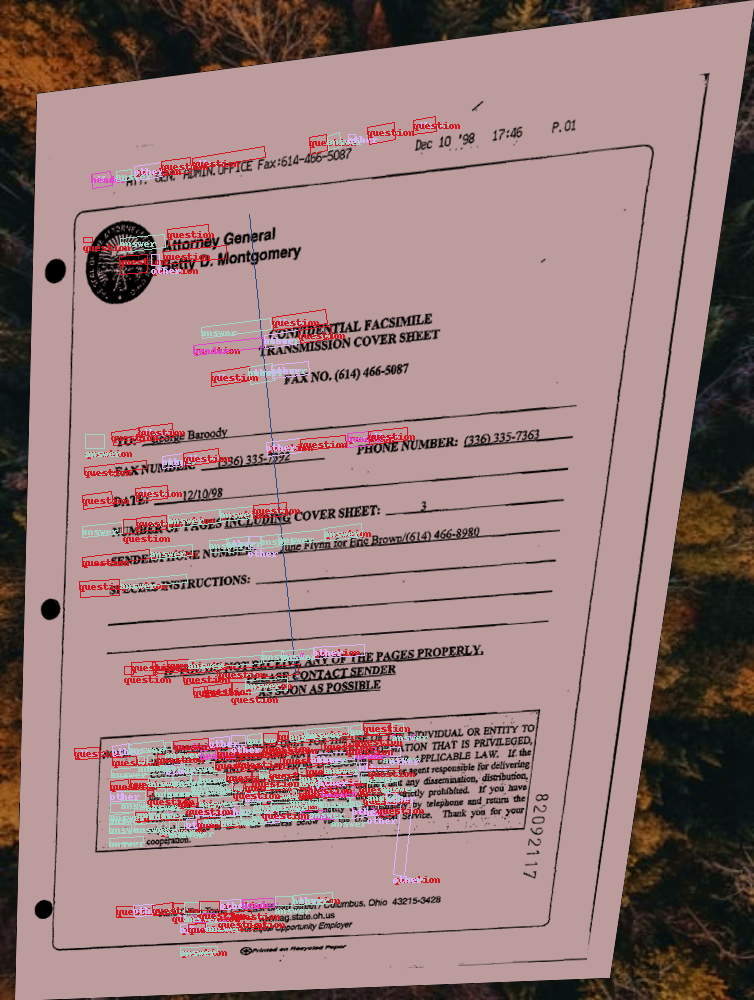

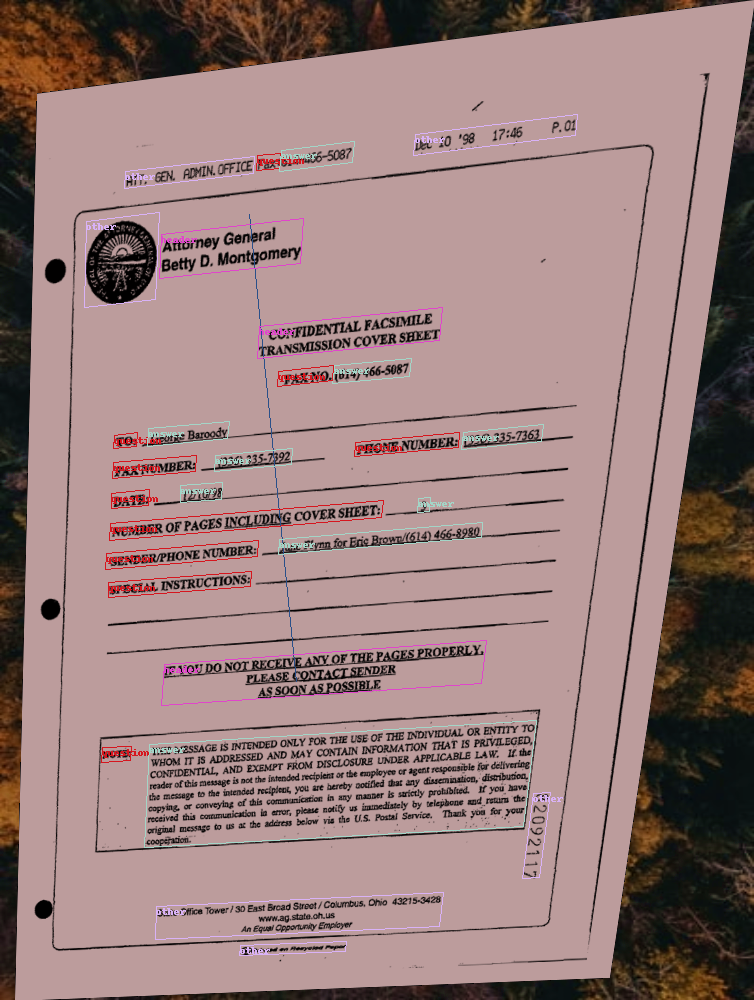

In [78]:
processor.feature_extractor.apply_ocr = False
pred_image = run_inference(inference_image.copy(), inference_image_ocr, True)


inference_annotation = json.load(open(test_dataset[0]['annotation_path'], 'r'))['form']
true_image = draw_polygons(inference_image.copy(), [ann['polygon'] for ann in inference_annotation], [ann['label'] for ann in inference_annotation], False)

# show side by side
from IPython.display import display
display(pred_image)
display(true_image)